In [2]:
# Import necessary libraries
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="1" # is needed for hachiko

from PIL import Image
import torch
import os
import warnings
warnings.filterwarnings("ignore")
from typing import Tuple

from PIL import Image
import torch
import torch.nn as nn
import torchvision.transforms as T
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

from datasets import load_dataset
import pandas as pd

import random
import json

import sys

# Adding the parent directory to the system path to import custom modules.
sys.path.append('..')

# Custom utility functions for validation, plotting, and training.
from validation_utils import custom_dataset, plot_confusion_matrix, get_trainer, get_compute_metrics

# Free up cached memory in GPU.
torch.cuda.empty_cache()

## MedViT

In [2]:
# Define the name of the pretrained model to be used.
pretrained_model_name = 'MedViT512_tr35_stage6(3)_CCropSpot2HTrivAug_fastvitprepr_lr1e5'

# Define the name of the dataset to be used.
dataset_name = 'DDR'

# Prepare the test dataset using the custom dataset function.
prepared_ds_test = custom_dataset(pretrained_model_name)

# Get the compute_metrics function customized for the specific pretrained model and dataset.
compute_metrics = get_compute_metrics(pretrained_model_name, dataset_name)

In [3]:
# Initialise a MedViT class
from transformers import PreTrainedModel
from MedViT.MedViT import MedViT, MedViT_large

# Define configuration
from transformers import PretrainedConfig
from typing import List

# Define a custom configuration class for MedViT
class MedViTConfig(PretrainedConfig):
    model_type = "medvit"

    def __init__(
        self,
        stem_chs: List[int] = [64, 32, 64],   # Stem channels for the model
        depths: List[int] = [3, 4, 30, 3],    # Depths of each stage in the model
        path_dropout: float = 0.2,            # Path dropout rate
        attn_drop: int = 0,                   # Attention dropout rate
        drop: int = 0,                        # Dropout rate
        num_classes: int = 5,                 # Number of output classes
        strides: List[int] = [1, 2, 2, 2],    # Stride values for each stage
        sr_ratios: List[int] = [8, 4, 2, 1],  # Spatial reduction ratios
        head_dim: int = 32,                   # Dimension of the head
        mix_block_ratio: float = 0.75,        # Mix block ratio
        use_checkpoint: bool = False,         # Whether to use checkpointing
        pretrained: bool = False,             # Whether to use pretrained weights
        pretrained_cfg: str = None,           # Configuration for pretrained weights
        **kwargs
    ):
        # Initialize configuration attributes
        self.stem_chs = stem_chs
        self.depths = depths
        self.path_dropout = path_dropout
        self.attn_drop = attn_drop
        self.drop = drop
        self.num_classes = num_classes
        self.strides = strides
        self.sr_ratios = sr_ratios
        self.head_dim = head_dim
        self.mix_block_ratio = mix_block_ratio
        self.use_checkpoint = use_checkpoint
        self.pretrained = pretrained,
        self.pretrained_cfg = pretrained_cfg
        super().__init__(**kwargs)

# Define a custom classification model based on MedViT
class MedViTClassification(PreTrainedModel):
    config_class = MedViTConfig

    def __init__(self, config, pretrained=False):
        super().__init__(config)

        # Initialize the model with random or pretrained weights
        if pretrained is False:
          print('Initialized with random weights:')
          self.model = MedViT(
          stem_chs = config.stem_chs,
          depths = config.depths,
          path_dropout = config.path_dropout,
          attn_drop = config.attn_drop,
          drop = config.drop,
          num_classes = config.num_classes,
          strides = config.strides,
          sr_ratios = config.sr_ratios,
          head_dim = config.head_dim,
          mix_block_ratio = config.mix_block_ratio,
          use_checkpoint = config.use_checkpoint)
        else:
          print('Initialized with pretrained weights:')
          self.model = MedViT_large(use_checkpoint = config.use_checkpoint)
          self.model.proj_head = nn.Linear(1024, 5)        

    def forward(self, pixel_values, labels=None):
        # Get model logits
        logits = self.model(pixel_values)
        
        # Compute loss if labels are provided
        if labels is not None:
            loss = torch.nn.functional.cross_entropy(logits, labels)
            return {"loss": loss, "logits": logits}
        # Return logits if no labels are provided
        return {"logits": logits}

# Load the pretrained model from the saved models directory
model = MedViTClassification.from_pretrained(f'../saved_models/{pretrained_model_name}')

# Initialize a trainer using the loaded model, prepared test dataset, and compute metrics function
trainer = get_trainer(model, prepared_ds_test, compute_metrics)

Initialized with random weights:
initialize_weights...


In [4]:
# Randomly select 100 samples from the prepared test dataset
sample_ids = np.random.choice(len(prepared_ds_test), size=100, replace=False)

# Find the indices that are not in the sample_ids to create an inverse sample set
inv_sample_ids = np.setdiff1d(np.arange(len(prepared_ds_test)), sample_ids)

# Create a validation dataset by selecting the samples with the randomly chosen sample_ids
val_ds = prepared_ds_test.select(sample_ids)

# Create a test dataset by selecting the remaining samples (not in sample_ids)
test_ds = prepared_ds_test.select(inv_sample_ids)

  0%|          | 0/3131 [00:00<?, ?it/s]

Normalized confusion matrix


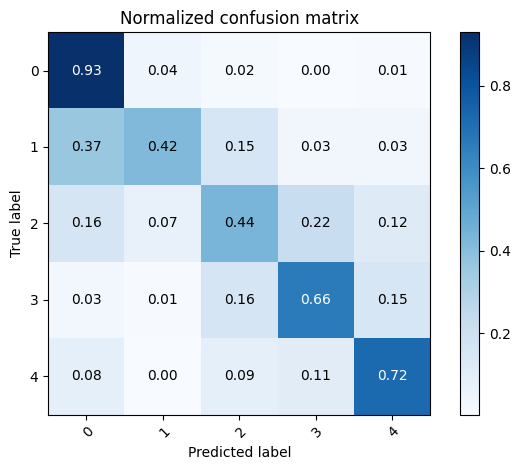

***** eval metrics *****
  eval_accuracy           =      0.707
  eval_class_0            =     0.8836
  eval_class_1            =      0.923
  eval_class_2            =     0.7734
  eval_class_3            =     0.9049
  eval_class_4            =     0.9291
  eval_f1                 =     0.7171
  eval_kappa              =     0.7722
  eval_loss               =     0.9102
  eval_roc_auc            =     0.8816
  eval_runtime            = 0:09:57.04
  eval_samples_per_second =     20.973
  eval_steps_per_second   =      5.244


In [6]:
# Evaluate the model using the entire test dataset
metrics = trainer.evaluate(prepared_ds_test)

# Log the evaluation metrics with the prefix "eval"
trainer.log_metrics("eval", metrics)

# Save the evaluation metrics to a JSON file
json.dump(metrics, open( f'../results/metrics_{pretrained_model_name}_{dataset_name}.json', 'w' ) )

## MedViT with ECA attention

In [2]:
# Define the name of the pretrained model
pretrained_model_name = 'MedViTAtt_to512_tr35_stage3(5)_selfpretrained_2'

# Define the name of the dataset being used
dataset_name = 'DDR'

# Load the custom dataset for testing, using the specified pretrained model name
prepared_ds_test = custom_dataset(pretrained_model_name)

# Get the metrics computation function specific to the pretrained model and dataset
compute_metrics = get_compute_metrics(pretrained_model_name, dataset_name)

In [8]:
# Import necessary modules
import math
from transformers import PreTrainedModel
from MedViT.MedViT import MedViT, MedViT_large

# Define the ECALayer class which adds attention mechanism
class ECALayer(nn.Module):
    def __init__(self, channels, gamma=2, b=1):
        super().__init__()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))         # Adaptive average pooling
        t = int(abs((math.log(channels, 2) + b) / gamma))   # Calculate kernel size
        k = t if t % 2 else t + 1                           # Ensure kernel size is odd
        self.conv = nn.Conv1d(1, 1, kernel_size=k, padding=(k - 1) // 2, bias=False)  # Convolution layer
        self.sigmoid = nn.Sigmoid()                         # Sigmoid activation

        # Initializing the weights with a uniform distribution 
        nn.init.uniform_(self.conv.weight) 

    def forward(self, x):
        y = self.avgpool(x)                 # Apply adaptive average pooling
        y = self.conv(y.squeeze(-1).transpose(-1, -2)).transpose(-1, -2).unsqueeze(-1)   # Apply convolution
        y = self.sigmoid(y)                 # Apply sigmoid activation
        return x * y.expand_as(x)           # Apply attention mechanism

# Define the MedViTClassification class which uses MedViT model
class MedViTClassification(PreTrainedModel):
    config_class = MedViTConfig

    def __init__(self, config, pretrained=False):
        super().__init__(config)

        # Initialize model with random weights if pretrained is False
        if pretrained is False:
          print('Initialized with random weights:')
          self.model = MedViT(
          stem_chs = config.stem_chs,
          depths = config.depths,
          path_dropout = config.path_dropout,
          attn_drop = config.attn_drop,
          drop = config.drop,
          num_classes = config.num_classes,
          strides = config.strides,
          sr_ratios = config.sr_ratios,
          head_dim = config.head_dim,
          mix_block_ratio = config.mix_block_ratio,
          use_checkpoint = config.use_checkpoint)

        # Initialize model with pretrained weights if pretrained is True
        else:
          print('Initialized with pretrained weights:')
          self.model = MedViT_large(use_checkpoint = config.use_checkpoint)
          self.model.proj_head = nn.Linear(1024, 5)       # Modify the projection head for classification
          nn.init.uniform_(self.model.proj_head.weight)   # Initialize projection head weights
        
        # Apply attention mechanism to specific layers
        self.apply_attention()

    def apply_attention(self):
        # Apply ECALayer attention mechanism to specific layers of the model
        self.model.features[6].e_mhsa = ECALayer(192)
        self.model.features[11].e_mhsa = ECALayer(384)
        self.model.features[16].e_mhsa = ECALayer(384)
        self.model.features[21].e_mhsa = ECALayer(384)
        
        self.model.features[26].e_mhsa = ECALayer(384)
        self.model.features[31].e_mhsa = ECALayer(384)
        self.model.features[36].e_mhsa = ECALayer(384)
        self.model.features[39].e_mhsa = ECALayer(768)

    def forward(self, pixel_values, labels=None):
        # Perform a forward pass through the model
        logits = self.model(pixel_values)

        # If labels are provided, compute the loss
        if labels is not None:
            loss = torch.nn.functional.cross_entropy(logits, labels)
            return {"loss": loss, "logits": logits}
        
        # Otherwise, just return the logits
        return {"logits": logits}

In [9]:
# Load a pre-trained MedViTClassification model from the specified directory
model = MedViTClassification.from_pretrained(f'../saved_models/{pretrained_model_name}')

# Initialize the trainer with the model, the test dataset, and the compute_metrics function
trainer = get_trainer(model, prepared_ds_test, compute_metrics)

Initialized with random weights:
initialize_weights...


  0%|          | 0/3131 [00:00<?, ?it/s]

Normalized confusion matrix


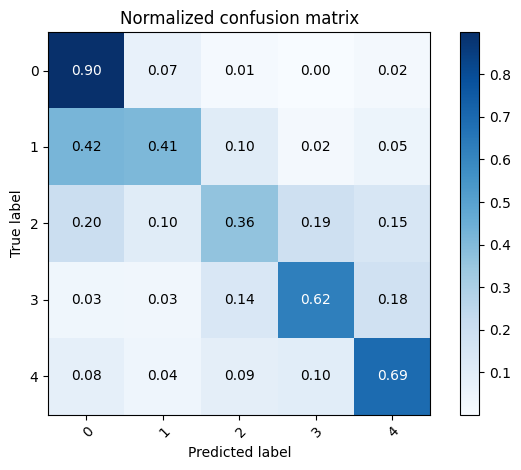

***** eval metrics *****
  eval_accuracy           =     0.6622
  eval_class_0            =     0.8507
  eval_class_1            =     0.8958
  eval_class_2            =      0.752
  eval_class_3            =     0.9164
  eval_class_4            =     0.9096
  eval_f1                 =     0.6688
  eval_kappa              =      0.716
  eval_loss               =     1.0105
  eval_roc_auc            =     0.8675
  eval_runtime            = 0:08:51.94
  eval_samples_per_second =      23.54
  eval_steps_per_second   =      5.886


In [10]:
# Evaluate the model on the prepared test dataset
metrics = trainer.evaluate(prepared_ds_test)

# Log the evaluation metrics with the label "eval"
trainer.log_metrics("eval", metrics)

# Save the evaluation metrics to a JSON file
json.dump(metrics, open( f'../results/metrics_{pretrained_model_name}_{dataset_name}.json', 'w' ) )

### EfficientNet

In [2]:
# Define the name of the pretrained model and dataset
pretrained_model_name = 'effNetb5_originpreprocessor_rt15'

# Define the name of the dataset being used
dataset_name = 'DDR'

# Prepare the test dataset using a custom dataset function with specified model name and resolution
prepared_ds_test = custom_dataset(pretrained_model_name, resolution=456)

# Get the function to compute evaluation metrics, specific to the pretrained model and dataset
compute_metrics = get_compute_metrics(pretrained_model_name, dataset_name)

In [3]:
from transformers import EfficientNetImageProcessor, EfficientNetForImageClassification
from validation_utils import labels, id2label, label2id

# Initialize the model for image classification
model = EfficientNetForImageClassification.from_pretrained(
    f'../saved_models/{pretrained_model_name}',       # Path to the pretrained model
    num_labels=len(labels),                           # Number of labels in the dataset
    id2label=id2label,                                # Mapping from label IDs to label names
    label2id=label2id,                                # Mapping from label names to label IDs
    ignore_mismatched_sizes=True,                     # Ignore images with mismatched sizes
)

# Create a trainer for the model using the prepared dataset and metrics computation function
trainer = get_trainer(model, prepared_ds_test, compute_metrics)

  0%|          | 0/3131 [00:00<?, ?it/s]

Normalized confusion matrix


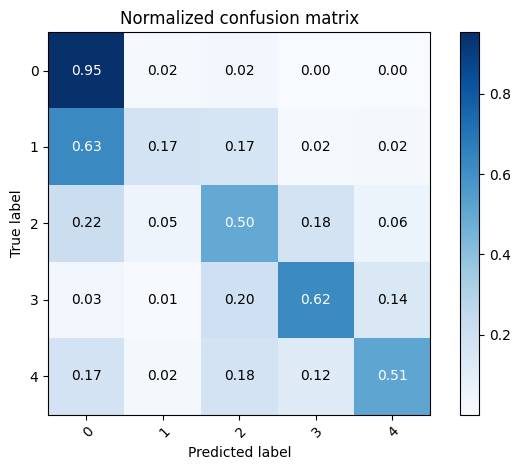

***** eval metrics *****
  eval_accuracy           =     0.7123
  eval_class_0            =     0.8541
  eval_class_1            =     0.9307
  eval_class_2            =     0.7833
  eval_class_3            =     0.9185
  eval_class_4            =     0.9379
  eval_f1                 =     0.7104
  eval_kappa              =      0.726
  eval_loss               =     1.0139
  eval_roc_auc            =     0.8617
  eval_runtime            = 0:03:14.29
  eval_samples_per_second =     64.449
  eval_steps_per_second   =     16.115


In [4]:
# Evaluate the model on the prepared test dataset
metrics = trainer.evaluate(prepared_ds_test)

# Log the evaluation metrics
trainer.log_metrics("eval", metrics)

# Save the evaluation metrics to a JSON file
json.dump(metrics, open( f'../results/metrics_{pretrained_model_name}_{dataset_name}.json', 'w' ) )

### Swin384 

In [4]:
# Define the name of the pretrained model and dataset
pretrained_model_name = 'swin384_originpreprocessor_rt15'

# Define the name of the dataset being used
dataset_name = 'DDR'

# Prepare the test dataset using a custom dataset function with specified model name and resolution
prepared_ds_test = custom_dataset(pretrained_model_name, resolution=384)

# Get the function to compute evaluation metrics, specific to the pretrained model and dataset
compute_metrics = get_compute_metrics(pretrained_model_name, dataset_name)

In [5]:
# Import necessary modules
from transformers import SwinForImageClassification
from validation_utils import labels, id2label, label2id

# Load the pre-trained Swin Transformer model for image classification
model = SwinForImageClassification.from_pretrained(
    f'../saved_models/{pretrained_model_name}',   # Path to the saved model
    num_labels=len(labels),                       # Number of labels for classification
    id2label=id2label,                            # Mapping of label IDs to label names
    label2id=label2id,                            # Mapping of label names to label IDs
    ignore_mismatched_sizes=True,                 # Ignore mismatched input image sizes during inference
)

# Create a trainer instance for evaluating the model
trainer = get_trainer(model, prepared_ds_test, compute_metrics)

  0%|          | 0/3131 [00:00<?, ?it/s]

Normalized confusion matrix


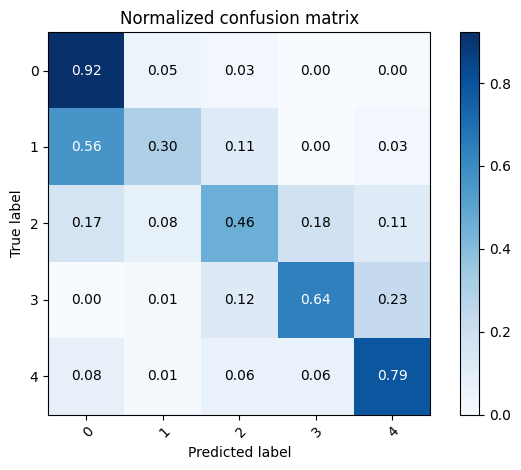

***** eval metrics *****
  eval_accuracy           =     0.7107
  eval_class_0            =     0.8684
  eval_class_1            =     0.9122
  eval_class_2            =     0.7816
  eval_class_3            =     0.9229
  eval_class_4            =     0.9363
  eval_f1                 =     0.7171
  eval_kappa              =     0.7852
  eval_loss               =     0.9354
  eval_roc_auc            =     0.8678
  eval_runtime            = 0:06:12.85
  eval_samples_per_second =     33.584
  eval_steps_per_second   =      8.397


In [6]:
# Evaluate the model on the prepared test dataset
metrics = trainer.evaluate(prepared_ds_test)

# Log the evaluation metrics
trainer.log_metrics("eval", metrics)

# Save the evaluation metrics to a JSON file
json.dump(metrics, open( f'../results/metrics_{pretrained_model_name}_{dataset_name}.json', 'w' ) )

In [15]:
import os
import pandas as pd
from glob import glob

# Dictionary containing pretrained model names and their corresponding saved model names
pretrained_model_names = {
    'MedViT_ECA': 'MedViTAtt_to512_tr35_stage3(5)_selfpretrained_2',
    'Swin384': 'swin384_originpreprocessor_rt15',
    'MedViT512': 'MedViT512_tr35_stage6(3)_CCropSpot2HTrivAug_fastvitprepr_lr1e5',
    # 'FastViT512': 'FasterViT512_tr35_randCrop',
    'EfficentNetb5': 'effNetb5_originpreprocessor_rt15'
}

# Dictionary to store metrics for different models
metrics = {}

# Flag to determine if it's the first iteration
first_flag = True

# Loop through each model
for model_name in pretrained_model_names:
    metrics_for_model = []
    if first_flag:
        metric_names = []

    # Open the JSON file containing metrics for the model
    with open(f'../results/metrics_{pretrained_model_names[model_name]}_DDR.json') as json_file:
        data = json.load(json_file)
        for metric_name in data:
            metrics_for_model.append(data[metric_name])
            if first_flag:
                metric_names.append(metric_name)

    if first_flag:
        # Store the metric names for the first model
        metrics['Metrics'] = metric_names  

    # Store the metrics for the current model
    metrics[model_name] = metrics_for_model
    
# Convert the metrics dictionary to a DataFrame
metrics = pd.DataFrame().from_dict(metrics).reset_index(drop=True)

# Display the metrics DataFrame
display(metrics)        

,Metrics,MedViT_ECA,Swin384,MedViT512,EfficentNetb5
0,eval_loss,1.010544,0.935449,0.910157,1.013949
1,eval_accuracy,0.662195,0.710669,0.706996,0.712266
2,eval_kappa,0.716013,0.785210,0.772248,0.726022
3,eval_f1,0.668762,0.717065,0.717059,0.710359
4,eval_roc_auc,0.867538,0.867825,0.881575,0.861664
5,eval_class_0,0.850663,0.868392,0.883645,0.854097
6,eval_class_1,0.895783,0.912155,0.923015,0.930682
7,eval_class_2,0.751957,0.781584,0.773359,0.783341
8,eval_class_3,0.916387,0.922936,0.904887,0.918464
9,eval_class_4,0.909599,0.936272,0.929085,0.937949
